## Optimizing Training Pipeline in Pytorch

To improve training performance in any deep learning pipeline, pytorch suggests few extra additions of codes in exitin pipeline.
These additions are explained and mentioned well here in [Performance Tuning Guide](https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html) . In this notebook you will encounter few of such features with hands-on dedicated for GPU Computing.

In [1]:
import os
import json
import time
import random
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

### Set GPU Device if multiple

In [3]:
!nvidia-smi

Thu Feb  3 10:39:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 455.38       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 20%   25C    P8    12W / 250W |      2MiB / 11178MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 20%   

In [4]:
##############################################################
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="2"
##############################################################

### Use device for `cuda` or `cpu` based on availability

In [5]:
####################################################################
#GPU using CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
####################################################################

device(type='cuda')

In [6]:
config = dict(
    IMAGE_PATH= "nih-dataset/nih-15-class",
    saved_path="saved/resnet18.pt",
    lr=0.001, 
    EPOCHS = 5,
    BATCH_SIZE = 32,
    IMAGE_SIZE = 224,
    TRAIN_VALID_SPLIT = 0.2,
    device=device,
    SEED = 42,
    pin_memory=True,
    num_workers=8,
    USE_AMP = True,
    channels_last=False)
####################################################################

In [7]:
# For custom operators, you might need to set python seed
random.seed(config['SEED'])
# If you or any of the libraries you are using rely on NumPy, you can seed the global NumPy RNG 
np.random.seed(config['SEED'])
# Prevent RNG for CPU and GPU using torch
torch.manual_seed(config['SEED'])
torch.cuda.manual_seed(config['SEED'])

### Create tensors directly on the target device

Instead of calling `torch.rand(size).cuda()` to generate a random tensor, produce the output directly on the target device: `torch.rand(size, device=torch.device('cuda'))`.

This is applicable to all functions which create new tensors and accept device argument: `torch.rand(), torch.zeros(), torch.full()` and similar.

CUDA Convolution Benchmarking: Best Convolution Algo but may loose reproducibility if True

In [8]:
# If researcher and wants to reproducuce: False
# If developer wants performance: True
torch.backends.cudnn.benchmarks = True
torch.backends.cudnn.deterministic = True

torch.backends.cuda.matmul.allow_tf32 = True

# The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
torch.backends.cudnn.allow_tf32 = True

Apply Data Transforms (Aumentations + Processing)

In [9]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop((224,224)),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((config['IMAGE_SIZE'],config['IMAGE_SIZE'])),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((config['IMAGE_SIZE'],config['IMAGE_SIZE'])),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [42]:
my_path = '../../../dataset/NIH_WHOLE_DATASET/nih-15-class'
os.listdir(my_path)

['Hernia',
 'Nodule',
 'Fibrosis',
 'Consolidation',
 'Cardiomegaly',
 'No Finding',
 'Emphysema',
 'Effusion',
 'Pneumothorax',
 'Pneumonia',
 'Atelectasis',
 'Infiltration',
 'Pleural_Thickening',
 'Edema',
 'Mass']

In [43]:
import torchvision
images = torchvision.datasets.ImageFolder(root=my_path,transform=data_transforms['test'])
print(len(images))
other, train_data,valid_data,test_data = torch.utils.data.dataset.random_split(images,[120000,1000,1000,19537])

141537


In [44]:
train_dl = torch.utils.data.DataLoader(dataset=train_data,batch_size=32,shuffle=True, num_workers = config['num_workers'],
                                          pin_memory = config['pin_memory'])
valid_dl = torch.utils.data.DataLoader(dataset = valid_data,batch_size=32,shuffle=True, num_workers = config['num_workers'],
                                          pin_memory = config['pin_memory'])
test_dl = torch.utils.data.DataLoader(dataset=test_data,batch_size=32,shuffle=True, num_workers = config['num_workers'],
                                          pin_memory = config['pin_memory'])

Optimizers:
Gradient Descent:-
    a. Stoicastic Gradient Descent bs = 1; 'n' number of examples. 'n / 1' number of data loader/steps for 1 Epoch
    b. Mini-Batch Gradient Descent bs = 32; 'n' number of examples. 'n / 32' number of dataloaders/step for 1 Epoch 
    c. Full Batch Gradient Descent bs = total_number_of_samples number of dataloader/steps = 1 for 1 Epoch

In [45]:
len(train_dl)

32

tensor([10, 10,  2,  1, 10, 10, 14,  1,  9, 10, 10,  4, 10, 10,  4,  4, 10,  4,
        11,  0, 10, 10,  8,  3,  0,  4, 10, 10,  0,  4, 10, 10])


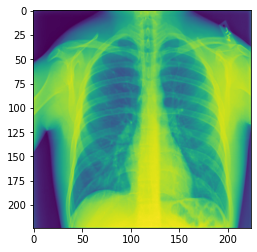

In [46]:
import matplotlib.pyplot as plt
a = iter(valid_dl)
b = next(a)
print(b[1])
plt.imshow(b[0][0][0])

Load Model : Pretrained from torchvision model zoo or Saved model

In [47]:
mobilenet = models.mobilenet_v2(pretrained=True)
mobilenet.classifier[1] = nn.Linear(in_features = 1280, out_features = 15, bias = True)
model = mobilenet
#print(model)

In [48]:
model.load_state_dict(torch.load('saved15/mobilenet_v2.pt'))

<All keys matched successfully>

In [49]:
#Channel Last Optimization in Model

model = model.to(config['device'])

In [50]:
optimizer = optim.Adam(model.parameters(),lr=config['lr'])
# Loss Function
criterion = nn.CrossEntropyLoss()

### Training Pipeline Starts

In [51]:
def train_model(model,criterion,optimizer,num_epochs=10):

    since = time.time()                                            
    batch_ct = 0
    example_ct = 0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        #Training
        model.train()
        run_corrects = 0
        for x,y in train_dl:
            x = x.to(config['device'])
            y = y.to(config['device'])
            
            optimizer.zero_grad()
            #optimizer.zero_grad(set_to_none=True)
            ######################################################################
            
            train_logits = model(x) #Input = [BS,3,224,224] (Image) -- Model --> [BS,4] (Output Scores)
            _, train_preds = torch.max(train_logits, 1)
            train_loss = criterion(train_logits,y)
            run_corrects += torch.sum(train_preds == y.data)
            
            train_loss.backward() # Backpropagation this is where your W_gradient
            loss=train_loss

            optimizer.step() # W_new = W_old - LR * W_gradient 
            example_ct += len(x) 
            batch_ct += 1
            
            ########################################################################
            # Stores Wandb Logs here
            # Report metrics every 25th batch
            if ((batch_ct + 1) % 25) == 0:
                train_log(loss, example_ct, epoch)
            ########################################################################
        
        #validation
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        total = 0
        # Disable gradient calculation for validation or inference using torch.no_rad()
        with torch.no_grad():
            for x,y in valid_dl:
                x = x.to(config['device'])
                y = y.to(config['device']) #CHW --> #HWC
                valid_logits = model(x)
                _, valid_preds = torch.max(valid_logits, 1)
                valid_loss = criterion(valid_logits,y)
                running_loss += valid_loss.item() * x.size(0)
                running_corrects += torch.sum(valid_preds == y.data)
                total += y.size(0)
            
        epoch_loss = running_loss / len(valid_data)
        epoch_acc = running_corrects.double() / len(valid_data)
        train_acc = run_corrects.double() / len(train_data)
        print("Train Accuracy",train_acc.cpu())
        print("Validation Loss is {}".format(epoch_loss))
        print("Validation Accuracy is {}".format(epoch_acc.cpu()))

            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    torch.save(model.state_dict(), config['saved_path'])

In [52]:
def train_log(loss, example_ct, epoch):
    loss = float(loss)
    print(f"Loss after " + str(example_ct).zfill(5) + f" examples: {loss:.3f}")

In [53]:
train_model(model, criterion, optimizer, num_epochs=2)

Epoch 0/1
----------
Loss after 00768 examples: 1.046
Train Accuracy tensor(0.6150, dtype=torch.float64)
Validation Loss is 1.1809197158813476
Validation Accuracy is 0.6
Epoch 1/1
----------
Loss after 01544 examples: 0.589
Train Accuracy tensor(0.7770, dtype=torch.float64)
Validation Loss is 1.169053906917572
Validation Accuracy is 0.601
Training complete in 0m 10s


In [54]:
import torch.nn.functional as F
model.eval()
running_loss = 0.0
running_corrects = 0
total = 0
preds = []
pred_labels = []
labels = []

        # Disable gradient calculation for validation or inference using torch.no_rad()
with torch.no_grad():
            for x,y in test_dl:
                x = x.to(config['device'])
                y = y.to(config['device']) #CHW --> #HWC
                valid_logits = model(x)
                predict_prob = F.softmax(valid_logits)
                _,predictions = predict_prob.max(1)
                predictions = predictions.to('cpu')
                
                _, valid_preds = torch.max(valid_logits, 1)
                valid_loss = criterion(valid_logits,y)
                running_loss += valid_loss.item() * x.size(0)
                running_corrects += torch.sum(valid_preds == y.data)
                total += y.size(0)
                predict_prob = predict_prob.to('cpu')
                
                pred_labels.extend(list(predictions.numpy()))
                preds.extend(list(predict_prob.numpy()))
                y = y.to('cpu')
                labels.extend(list(y.numpy()))
            
epoch_loss = running_loss / len(test_data)
epoch_acc = running_corrects.double() / len(test_data)
print("Test Loss is {}".format(epoch_loss))
print("Test Accuracy is {}".format(epoch_acc.cpu()))

Test Loss is 1.1599970828329351
Test Accuracy is 0.6085888314480217


In [55]:
# Mobilenet v2
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
precision_recall_fscore_support(np.array(labels), np.array(pred_labels))

(array([0.40947213, 0.5011655 , 0.23076923, 0.29674797, 0.36837881,
        0.43072289, 0.46268657, 0.3559322 , 0.42648752, 0.4612069 ,
        0.84594686, 0.49456522, 0.27868852, 0.33333333, 0.43717277]),
 array([0.50333535, 0.51682692, 0.00473186, 0.43195266, 0.50690226,
        0.43865031, 0.2952381 , 0.61764706, 0.39509246, 0.39242054,
        0.91532209, 0.21138211, 0.11460674, 0.03883495, 0.45504087]),
 array([0.4515778 , 0.50887574, 0.00927357, 0.35180723, 0.42667906,
        0.43465046, 0.36046512, 0.4516129 , 0.41019014, 0.42404227,
        0.87926815, 0.29617575, 0.16242038, 0.06956522, 0.4459279 ]),
 array([1649,  416,  634,  338, 1811,  326,  210,   34, 2812,  818, 8243,
         861,  445,  206,  734]))

In [56]:
#y_pred = np.transpose([pred[:, 1] for pred in preds])
roc_auc_score(np.array(labels), np.array(preds), multi_class='ovr')

0.9153915675086051

## ExLNet

In [57]:
squeezenet = torchvision.models.squeezenet1_0(pretrained=True)

squeezenet.features[3].expand1x1 = nn.Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1),groups=16)
squeezenet.features[3].expand3x3 = nn.Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=16)

squeezenet.features[4].expand1x1 = nn.Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1),groups=16)
squeezenet.features[4].expand3x3 = nn.Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=16)

squeezenet.features[5].expand1x1 = nn.Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1),groups=32)
squeezenet.features[5].expand3x3 = nn.Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=32)

squeezenet.features[7].expand1x1 = nn.Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1),groups=32)
squeezenet.features[7].expand3x3 = nn.Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=32)

squeezenet.features[8].expand1x1 = nn.Conv2d(48, 192, kernel_size=(1, 1), stride=(1, 1),groups=48)
squeezenet.features[8].expand3x3 = nn.Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=48)

squeezenet.features[9].expand1x1 = nn.Conv2d(48, 192, kernel_size=(1, 1), stride=(1, 1),groups=48)
squeezenet.features[9].expand3x3 = nn.Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=48)

squeezenet.features[10].expand1x1 = nn.Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1),groups=64)
squeezenet.features[10].expand3x3 = nn.Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=64)

squeezenet.features[12].expand1x1 = nn.Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1),groups=64)
squeezenet.features[12].expand3x3 = nn.Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=64)

squeezenet.classifier = nn.Sequential(
                                        nn.Dropout(0.5),
                                        nn.Conv2d(512, 15, kernel_size=(1, 1), stride=(1, 1)),
                                        nn.AdaptiveAvgPool2d(output_size=(1, 1))
        )

model = squeezenet
model.load_state_dict(torch.load('saved15/exlnet2_best.pt'))

<All keys matched successfully>

In [58]:
model = model.to(config['device'])

In [59]:
model.eval()
running_loss = 0.0
running_corrects = 0
total = 0
preds = []
pred_labels = []
labels = []

        # Disable gradient calculation for validation or inference using torch.no_rad()
with torch.no_grad():
            for x,y in test_dl:
                x = x.to(config['device'])
                y = y.to(config['device']) #CHW --> #HWC
                valid_logits = model(x)
                predict_prob = F.softmax(valid_logits)
                _,predictions = predict_prob.max(1)
                predictions = predictions.to('cpu')
                
                _, valid_preds = torch.max(valid_logits, 1)
                valid_loss = criterion(valid_logits,y)
                running_loss += valid_loss.item() * x.size(0)
                running_corrects += torch.sum(valid_preds == y.data)
                total += y.size(0)
                predict_prob = predict_prob.to('cpu')
                
                pred_labels.extend(list(predictions.numpy()))
                preds.extend(list(predict_prob.numpy()))
                y = y.to('cpu')
                labels.extend(list(y.numpy()))
            
epoch_loss = running_loss / len(test_data)
epoch_acc = running_corrects.double() / len(test_data)
print("Test Loss is {}".format(epoch_loss))
print("Test Accuracy is {}".format(epoch_acc.cpu()))

Test Loss is 1.4526316547196103
Test Accuracy is 0.516251215642115


In [60]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
precision_recall_fscore_support(np.array(labels), np.array(pred_labels))

(array([0.34456929, 0.47368421, 0.45454545, 0.36206897, 0.3290616 ,
        0.31496063, 0.375     , 0.5       , 0.30611407, 0.31707317,
        0.64975951, 0.31460674, 0.27210884, 0.        , 0.33604336]),
 array([0.22316555, 0.30288462, 0.01577287, 0.06213018, 0.43953617,
        0.12269939, 0.02857143, 0.05882353, 0.26529161, 0.20660147,
        0.90137086, 0.09756098, 0.08988764, 0.        , 0.33787466]),
 array([0.27088701, 0.36950147, 0.0304878 , 0.10606061, 0.37635934,
        0.17660044, 0.05309735, 0.10526316, 0.28424462, 0.25018505,
        0.75515804, 0.14893617, 0.13513514, 0.        , 0.33695652]),
 array([1649,  416,  634,  338, 1811,  326,  210,   34, 2812,  818, 8243,
         861,  445,  206,  734]))

In [61]:
roc_auc_score(np.array(labels), np.array(preds), multi_class='ovr')

0.8581357246732239

## ResNet 50

In [62]:
resnet50 = torchvision.models.resnet50(pretrained=True)
resnet50.fc = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(in_features = 2048, out_features = 15, bias = True))
model = resnet50

model.load_state_dict(torch.load('saved15/resnet50_best.pt'))
model = model.to(config['device'])

In [63]:
model.eval()
running_loss = 0.0
running_corrects = 0
total = 0
preds = []
pred_labels = []
labels = []

        # Disable gradient calculation for validation or inference using torch.no_rad()
with torch.no_grad():
            for x,y in test_dl:
                x = x.to(config['device'])
                y = y.to(config['device']) #CHW --> #HWC
                valid_logits = model(x)
                predict_prob = F.softmax(valid_logits)
                _,predictions = predict_prob.max(1)
                predictions = predictions.to('cpu')
                
                _, valid_preds = torch.max(valid_logits, 1)
                valid_loss = criterion(valid_logits,y)
                running_loss += valid_loss.item() * x.size(0)
                running_corrects += torch.sum(valid_preds == y.data)
                total += y.size(0)
                predict_prob = predict_prob.to('cpu')
                
                pred_labels.extend(list(predictions.numpy()))
                preds.extend(list(predict_prob.numpy()))
                y = y.to('cpu')
                labels.extend(list(y.numpy()))
            
epoch_loss = running_loss / len(test_data)
epoch_acc = running_corrects.double() / len(test_data)
print("Test Loss is {}".format(epoch_loss))
print("Test Accuracy is {}".format(epoch_acc.cpu()))

Test Loss is 1.0680189470420591
Test Accuracy is 0.6463121257101909


In [64]:
precision_recall_fscore_support(np.array(labels), np.array(pred_labels))

(array([0.52960801, 0.61656442, 0.31455399, 0.44573643, 0.41772152,
        0.50896057, 0.45714286, 0.5       , 0.42605289, 0.45823096,
        0.9164342 , 0.46116505, 0.45564516, 0.54545455, 0.44917012]),
 array([0.38508187, 0.48317308, 0.10567823, 0.34023669, 0.4737714 ,
        0.43558282, 0.45714286, 0.20588235, 0.61877667, 0.45599022,
        0.91665656, 0.33101045, 0.25393258, 0.02912621, 0.58991826]),
 array([0.44592697, 0.54177898, 0.15820543, 0.38590604, 0.44398448,
        0.46942149, 0.45714286, 0.29166667, 0.50464037, 0.45710784,
        0.91654537, 0.38539554, 0.32611833, 0.05529954, 0.51001178]),
 array([1649,  416,  634,  338, 1811,  326,  210,   34, 2812,  818, 8243,
         861,  445,  206,  734]))

In [65]:
roc_auc_score(np.array(labels), np.array(preds), multi_class='ovr')

0.928361832344621